In [1]:
# [START import]
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import numpy as np
# [END import]
import time


In [2]:
# [START solution_printer]
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    # [END solution_printer]

# 读数据

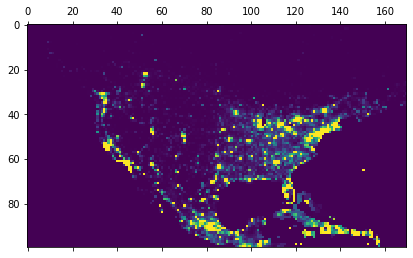

In [3]:
ascii_grid = np.loadtxt("/Users/shuffle_new/Desktop/Prelim/Modeling/Data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_min_asc/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_30_min.asc", skiprows=6)
order_density = ascii_grid
order_density[order_density == -9999] = 0
order_density[order_density > 200] = 200
order_density = order_density[50:150, 80:250]
plt.matshow(order_density)

In [4]:
x_len = np.shape(order_density)[0]
y_len = np.shape(order_density)[1]

# 实验1:cover 全部订单，每个仓库指定车辆数量，起点终点必须是同一个仓库

In [17]:
N_depot = 3

# depot_loc_ls = np.array([[40,60, 90],[40,100,80]])
depot_loc_ls = np.array([[20,90, 40],[20,80,140]])

In [18]:

N_order = 100
# 200个 3s
# 300个 7s



order_loc_ls = np.zeros((2,N_order))
max_density = np.max(order_density)
max_sample = 30000
order_sampled = 0
for i in range(max_sample):
    random_loc_x = np.random.rand()*x_len
    random_loc_y = np.random.rand()*y_len
    if order_density[int(random_loc_x), int(random_loc_y)]/max_density > np.random.rand():
        order_loc_ls[:,order_sampled] = [random_loc_x, random_loc_y]
        order_sampled += 1
        if order_sampled >= N_order:
            break
print(order_sampled)

order_demands = np.random.randint(5,10,size=N_order)

100


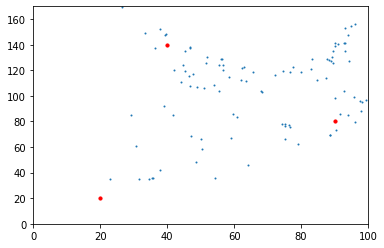

In [19]:
plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=1)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len);

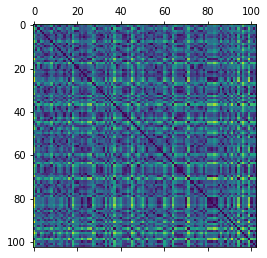

In [20]:
def create_data_model(order_loc_ls, depot_loc_ls, order_demands):
    
    node_loc_ls = np.concatenate((depot_loc_ls, order_loc_ls),axis=1)
    N_order = np.shape(order_loc_ls)[1]
    N_depot = np.shape(depot_loc_ls)[1]

    distance_matrix = np.zeros((N_order+N_depot, N_order+N_depot))

    for i in range(N_order+N_depot):
        for j in range(i+1, N_order+N_depot):
    #         print(i,j)
            distance_matrix[i,j] = np.linalg.norm([node_loc_ls[0,i]-node_loc_ls[0,j],node_loc_ls[1,i]-node_loc_ls[1,j]])
            distance_matrix[j,i] = distance_matrix[i,j]


    node_demands = np.concatenate((np.zeros(N_depot),order_demands))
    """Stores the data for the problem."""
    data = {}
    data['node_loc_ls'] = node_loc_ls
    data['distance_matrix'] = distance_matrix
    # [START demands_capacities]
    data['demands'] = node_demands
    
    N_vehicle_each_depot = 5

    data['num_vehicles'] = N_depot * N_vehicle_each_depot
    data['vehicle_capacities'] = np.ones(data['num_vehicles'])*200
    # [END demands_capacities]
    
#     data['depot'] = 0
    data['starts'] = [0,1,2]*N_vehicle_each_depot
    data['ends'] = [0,1,2]*N_vehicle_each_depot
    return data
    # [END data_model]
plt.matshow(create_data_model(order_loc_ls, depot_loc_ls, order_demands)['distance_matrix'])

In [21]:
"""Entry point of the program."""
time_start = time.time()
# Instantiate the data problem.
data = create_data_model(order_loc_ls, depot_loc_ls, order_demands)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['starts'],
                                       data['ends'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
# [START transit_callback]
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# [END transit_callback]

# Define cost of each arc.
# [START arc_cost]
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# [END arc_cost]

# Add Capacity constraint.
# [START capacity_constraint]
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# [END capacity_constraint]

# Setting first solution heuristic.
# [START parameters]
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.seconds = 10
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)


# search_parameters.local_search_metaheuristic = (
#     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
# search_parameters.log_search = True
# [END parameters]

# Solve the problem.
# [START solve]
solution = routing.SolveWithParameters(search_parameters)
# [END solve]

# Print solution on console.
# [START print_solution]
# if solution:
#     print_solution(data, manager, routing, solution)
# [END print_solution]

time_end = time.time()

print('time consumed: '+str(time_end - time_start))
print("Solver status: ", routing.status())

time consumed: 0.7529301643371582
Solver status:  1


In [22]:
# Value	Description
# 0	ROUTING_NOT_SOLVED: Problem not solved yet.
# 1	ROUTING_SUCCESS: Problem solved successfully.
# 2	ROUTING_FAIL: No solution found to the problem.
# 3	ROUTING_FAIL_TIMEOUT: Time limit reached before finding a solution.
# 4	ROUTING_INVALID: Model, model parameters, or flags are not valid.

In [23]:
# [START solution_printer]
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    # [END solution_printer]

total distance: 735


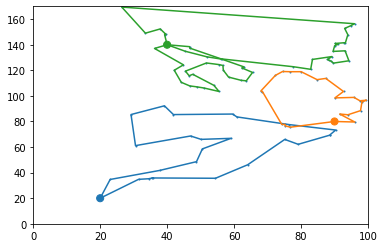

In [24]:
total_distance = 0
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    route_distance = 0
    node_ls = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        node_ls.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
    node_ls.append(manager.IndexToNode(index))
    
    
    total_distance += route_distance
    
    for i in range(N_depot):
        if i in node_ls:
            depot_used = i
    route_x = data['node_loc_ls'][0,node_ls]
    route_y = data['node_loc_ls'][1,node_ls]
    
    plt.plot(route_x, route_y, c='C'+str(depot_used))

plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=1)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=50,c=['C'+str(i) for i in range(N_depot)])
plt.xlim(0,x_len)
plt.ylim(0,y_len)
print('total distance: '+str(total_distance))

# 实验2:订单多了，随机筛选

In [25]:
N_depot = 3

# depot_loc_ls = np.array([[40,60, 90],[40,100,80]])
depot_loc_ls = np.array([[20,90, 40],[20,80,140]])

In [27]:
# 每天订单数量
N_total_order = 300
# 系统设定最多这么多
N_order = 100
# 200个 3s
# 300个 7s



order_loc_ls = np.zeros((2,N_total_order))
max_density = np.max(order_density)
max_sample = 30000
order_sampled = 0
for i in range(max_sample):
    random_loc_x = np.random.rand()*x_len
    random_loc_y = np.random.rand()*y_len
    if order_density[int(random_loc_x), int(random_loc_y)]/max_density > np.random.rand():
        order_loc_ls[:,order_sampled] = [random_loc_x, random_loc_y]
        order_sampled += 1
        if order_sampled >= N_total_order:
            break
print(order_sampled)
order_demands = np.random.randint(5,10,size=N_total_order)
saved_order = np.random.choice(N_total_order,N_order)
saved_order_demands = order_demands[saved_order]

300


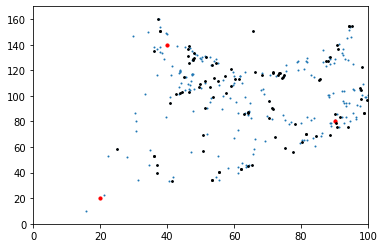

In [28]:
plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=1)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')


plt.xlim(0,x_len)
plt.ylim(0,y_len);

saved_order_loc_ls = order_loc_ls[:,saved_order]
plt.scatter(saved_order_loc_ls[0,:],saved_order_loc_ls[1,:],s=3,c='k')
plt.xlim(0,x_len)
plt.ylim(0,y_len);

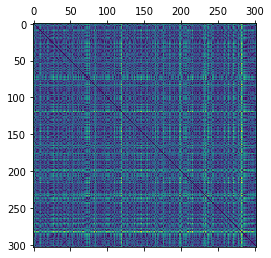

In [29]:
def create_data_model(order_loc_ls, depot_loc_ls, order_demands):
    
    node_loc_ls = np.concatenate((depot_loc_ls, order_loc_ls),axis=1)
    N_order = np.shape(order_loc_ls)[1]
    N_depot = np.shape(depot_loc_ls)[1]

    distance_matrix = np.zeros((N_order+N_depot, N_order+N_depot))

    for i in range(N_order+N_depot):
        for j in range(i+1, N_order+N_depot):
    #         print(i,j)
            distance_matrix[i,j] = np.linalg.norm([node_loc_ls[0,i]-node_loc_ls[0,j],node_loc_ls[1,i]-node_loc_ls[1,j]])
            distance_matrix[j,i] = distance_matrix[i,j]


    node_demands = np.concatenate((np.zeros(N_depot),order_demands))
    """Stores the data for the problem."""
    data = {}
    data['node_loc_ls'] = node_loc_ls
    data['distance_matrix'] = distance_matrix
    # [START demands_capacities]
    data['demands'] = node_demands
    
    N_vehicle_each_depot = 5

    data['num_vehicles'] = N_depot * N_vehicle_each_depot
    data['vehicle_capacities'] = np.ones(data['num_vehicles'])*200
    # [END demands_capacities]
    
#     data['depot'] = 0
    data['starts'] = [0,1,2]*N_vehicle_each_depot
    data['ends'] = [0,1,2]*N_vehicle_each_depot
    return data
    # [END data_model]
plt.matshow(create_data_model(order_loc_ls, depot_loc_ls, order_demands)['distance_matrix'])

In [30]:
"""Entry point of the program."""
time_start = time.time()
# Instantiate the data problem.
data = create_data_model(saved_order_loc_ls, depot_loc_ls, saved_order_demands)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['starts'],
                                       data['ends'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
# [START transit_callback]
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# [END transit_callback]

# Define cost of each arc.
# [START arc_cost]
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# [END arc_cost]

# Add Capacity constraint.
# [START capacity_constraint]
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# [END capacity_constraint]

# Setting first solution heuristic.
# [START parameters]
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.seconds = 10
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)


# search_parameters.local_search_metaheuristic = (
#     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
# search_parameters.log_search = True
# [END parameters]

# Solve the problem.
# [START solve]
solution = routing.SolveWithParameters(search_parameters)
# [END solve]

# Print solution on console.
# [START print_solution]
# if solution:
#     print_solution(data, manager, routing, solution)
# [END print_solution]

time_end = time.time()

print('time consumed: '+str(time_end - time_start))
print("Solver status: ", routing.status())

time consumed: 0.9557812213897705
Solver status:  1


In [31]:
# Value	Description
# 0	ROUTING_NOT_SOLVED: Problem not solved yet.
# 1	ROUTING_SUCCESS: Problem solved successfully.
# 2	ROUTING_FAIL: No solution found to the problem.
# 3	ROUTING_FAIL_TIMEOUT: Time limit reached before finding a solution.
# 4	ROUTING_INVALID: Model, model parameters, or flags are not valid.

In [32]:
# [START solution_printer]
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    # [END solution_printer]

total distance: 699


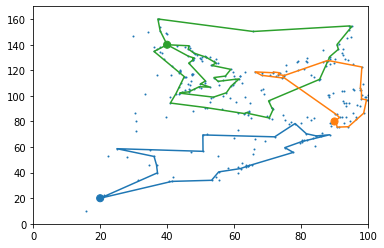

In [33]:
total_distance = 0
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    route_distance = 0
    node_ls = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        node_ls.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
    node_ls.append(manager.IndexToNode(index))
    
    
    total_distance += route_distance
    
    for i in range(N_depot):
        if i in node_ls:
            depot_used = i
    route_x = data['node_loc_ls'][0,node_ls]
    route_y = data['node_loc_ls'][1,node_ls]
    
    plt.plot(route_x, route_y, c='C'+str(depot_used))

plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=1)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=50,c=['C'+str(i) for i in range(N_depot)])
plt.xlim(0,x_len)
plt.ylim(0,y_len)
print('total distance: '+str(total_distance))

# 实验3:订单多了，先全部接了，然后按照每日运力进行分配

In [34]:
N_depot = 3

# depot_loc_ls = np.array([[40,60, 90],[40,100,80]])
depot_loc_ls = np.array([[20,90, 40],[20,80,140]])

In [35]:

N_order = 300
# 200个 3s
# 300个 7s



order_loc_ls = np.zeros((2,N_order))
max_density = np.max(order_density)
max_sample = 30000
order_sampled = 0
for i in range(max_sample):
    random_loc_x = np.random.rand()*x_len
    random_loc_y = np.random.rand()*y_len
    if order_density[int(random_loc_x), int(random_loc_y)]/max_density > np.random.rand():
        order_loc_ls[:,order_sampled] = [random_loc_x, random_loc_y]
        order_sampled += 1
        if order_sampled >= N_order:
            break
print(order_sampled)

order_demands = np.random.randint(5,10,size=N_order)

300


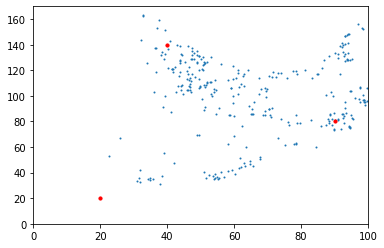

In [36]:
plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=1)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len);

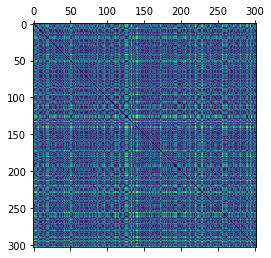

In [37]:
def create_data_model(order_loc_ls, depot_loc_ls, order_demands):
    
    node_loc_ls = np.concatenate((depot_loc_ls, order_loc_ls),axis=1)
    N_order = np.shape(order_loc_ls)[1]
    N_depot = np.shape(depot_loc_ls)[1]

    distance_matrix = np.zeros((N_order+N_depot, N_order+N_depot))

    for i in range(N_order+N_depot):
        for j in range(i+1, N_order+N_depot):
    #         print(i,j)
            distance_matrix[i,j] = np.linalg.norm([node_loc_ls[0,i]-node_loc_ls[0,j],node_loc_ls[1,i]-node_loc_ls[1,j]])
            distance_matrix[j,i] = distance_matrix[i,j]


    node_demands = np.concatenate((np.zeros(N_depot),order_demands))
    """Stores the data for the problem."""
    data = {}
    data['node_loc_ls'] = node_loc_ls
    data['distance_matrix'] = distance_matrix
    # [START demands_capacities]
    data['demands'] = node_demands
    
    N_vehicle_each_depot = 5

    data['num_vehicles'] = N_depot * N_vehicle_each_depot
    data['vehicle_capacities'] = np.ones(data['num_vehicles'])*200
    # [END demands_capacities]
    
#     data['depot'] = 0
    data['starts'] = [0,1,2]*N_vehicle_each_depot
    data['ends'] = [0,1,2]*N_vehicle_each_depot
    return data
    # [END data_model]
plt.matshow(create_data_model(order_loc_ls, depot_loc_ls, order_demands)['distance_matrix'])

In [38]:
"""Entry point of the program."""
time_start = time.time()
# Instantiate the data problem.
data = create_data_model(order_loc_ls, depot_loc_ls, order_demands)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['starts'],
                                       data['ends'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
# [START transit_callback]
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# [END transit_callback]

# Define cost of each arc.
# [START arc_cost]
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# [END arc_cost]

# Add Capacity constraint.
# [START capacity_constraint]
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# [END capacity_constraint]

# Setting first solution heuristic.
# [START parameters]
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.seconds = 20
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)


# search_parameters.local_search_metaheuristic = (
#     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
# search_parameters.log_search = True
# [END parameters]

# Solve the problem.
# [START solve]
solution = routing.SolveWithParameters(search_parameters)
# [END solve]

# Print solution on console.
# [START print_solution]
if solution:
    print_solution(data, manager, routing, solution)
# [END print_solution]

time_end = time.time()

print('time consumed: '+str(time_end - time_start))
print("Solver status: ", routing.status())

Route for vehicle 0:
 0 Load(0.0) ->  0 Load(0.0)
Distance of the route: 0m
Load of the route: 0.0

Route for vehicle 1:
 1 Load(0.0) ->  82 Load(7.0) ->  33 Load(15.0) ->  181 Load(20.0) ->  195 Load(27.0) ->  36 Load(36.0) ->  266 Load(45.0) ->  210 Load(50.0) ->  272 Load(57.0) ->  64 Load(64.0) ->  159 Load(73.0) ->  71 Load(82.0) ->  85 Load(87.0) ->  214 Load(95.0) ->  148 Load(104.0) ->  200 Load(109.0) ->  163 Load(114.0) ->  60 Load(121.0) ->  72 Load(126.0) ->  188 Load(132.0) ->  201 Load(138.0) ->  99 Load(147.0) ->  154 Load(155.0) ->  292 Load(164.0) ->  242 Load(169.0) ->  114 Load(177.0) ->  91 Load(183.0) ->  232 Load(188.0) ->  249 Load(195.0) ->  28 Load(200.0) ->  1 Load(200.0)
Distance of the route: 117m
Load of the route: 200.0

Route for vehicle 2:
 2 Load(0.0) ->  2 Load(0.0)
Distance of the route: 0m
Load of the route: 0.0

Route for vehicle 3:
 0 Load(0.0) ->  0 Load(0.0)
Distance of the route: 0m
Load of the route: 0.0

Route for vehicle 4:
 1 Load(0.0) ->  2

In [39]:
# Value	Description
# 0	ROUTING_NOT_SOLVED: Problem not solved yet.
# 1	ROUTING_SUCCESS: Problem solved successfully.
# 2	ROUTING_FAIL: No solution found to the problem.
# 3	ROUTING_FAIL_TIMEOUT: Time limit reached before finding a solution.
# 4	ROUTING_INVALID: Model, model parameters, or flags are not valid.

In [40]:
# [START solution_printer]
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    # [END solution_printer]

In [41]:
# vehicle_route: 每个vehicle走的route
vehicle_route = {}

for vehicle_id in range(data['num_vehicles']):
    this_vehicle_distance = 0
    this_vehicle_node_ls = []
    index = routing.Start(vehicle_id)
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        this_vehicle_node_ls.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        this_vehicle_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
    this_vehicle_node_ls.append(manager.IndexToNode(index))
    if this_vehicle_distance != 0:
        vehicle_route[vehicle_id] = {'route':np.array(this_vehicle_node_ls), 'distance':this_vehicle_distance}

In [59]:
# bin packing problem

import cvxpy as cp

n_running_vehicle = len(vehicle_route)
y = cp.Variable(n_running_vehicle, boolean=True)

# x[i][j] 表示 第i辆车是否在第j天运营
x = cp.Variable((n_running_vehicle,n_running_vehicle),boolean=True)

one_day_capacity = 650

constraints = []

# day
for j in range(n_running_vehicle):
    day_j_dist = 0
    # vehicle
    for i in range(n_running_vehicle):
        day_j_dist += list(vehicle_route.values())[i]['distance']*x[i][j]
    constraints.append(day_j_dist <= one_day_capacity * y[j])
    
constraints.append(cp.sum(x,axis=1) == 1)

objective = cp.Minimize(cp.sum(y))
prob = cp.Problem(objective, constraints)
result = prob.solve()
print('total days needed is : '+str(result))

# x_val_cleaned 相当于让day 的index从0开始并且连续
x_val_cleaned = x.value[:,np.argsort(y.value)[::-1]]

dist_each_day = np.zeros(int(result))

for i in range(n_running_vehicle):
    day_for_current_vehicle = np.where(x_val_cleaned[i,:] == 1)[0][0]
    vehicle_route[list(vehicle_route.keys())[i]]['day'] = day_for_current_vehicle
    dist_each_day[day_for_current_vehicle] += vehicle_route[list(vehicle_route.keys())[i]]['distance']

print('distance each day: ',dist_each_day)

total days needed is : 2.0
distance each day:  [635. 642.]


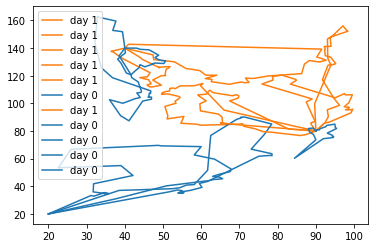

In [60]:
for vehicle_id in vehicle_route.keys():
    node_ls = vehicle_route[vehicle_id]['route']
    route_x = data['node_loc_ls'][0,node_ls]
    route_y = data['node_loc_ls'][1,node_ls]
    day_id = vehicle_route[vehicle_id]['day']
    plt.plot(route_x, route_y, c='C'+str(day_id),label='day '+str(day_id))
plt.legend()

# 开始随机订单

# 实验4: 实验3多次生成order，看划分有没有分布

In [25]:
import progressbar

In [31]:
N_customer = 1000
p_buy_one_day = 50/N_customer
N_exper = 1000


N_depot = 3
# depot_loc_ls = np.array([[40,60, 90],[40,100,80]])
depot_loc_ls = np.array([[20,90, 40],[20,80,140]])

1000


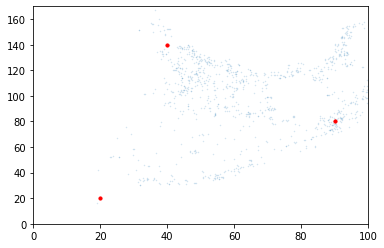

In [32]:
# sample location of customer
customer_loc_ls = np.zeros((2,N_customer))
max_density = np.max(order_density)
max_sample = N_customer*50
customer_sampled = 0
for i in range(max_sample):
    random_loc_x = np.random.rand()*x_len
    random_loc_y = np.random.rand()*y_len
    if order_density[int(random_loc_x), int(random_loc_y)]/max_density > np.random.rand():
        customer_loc_ls[:,customer_sampled] = [random_loc_x, random_loc_y]
        customer_sampled += 1
        if customer_sampled >= N_customer:
            break
print(customer_sampled)

plt.scatter(customer_loc_ls[0,:],customer_loc_ls[1,:],s=0.2,alpha=0.2)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len);

In [33]:
connection_result = np.zeros((N_exper,N_depot+N_customer,N_depot+N_customer))
solve_statue_result = np.zeros(N_exper)
distance_result = np.zeros(N_exper)
N_order_record = np.zeros(N_exper)

In [34]:
def create_data_model(order_loc_ls, depot_loc_ls, order_demands):
    
    node_loc_ls = np.concatenate((depot_loc_ls, order_loc_ls),axis=1)
    N_order = np.shape(order_loc_ls)[1]
    N_depot = np.shape(depot_loc_ls)[1]

    distance_matrix = np.zeros((N_order+N_depot, N_order+N_depot))

    for i in range(N_order+N_depot):
        for j in range(i+1, N_order+N_depot):
    #         print(i,j)
            distance_matrix[i,j] = np.linalg.norm([node_loc_ls[0,i]-node_loc_ls[0,j],node_loc_ls[1,i]-node_loc_ls[1,j]])
            distance_matrix[j,i] = distance_matrix[i,j]


    node_demands = np.concatenate((np.zeros(N_depot),order_demands))
    """Stores the data for the problem."""
    data = {}
    data['node_loc_ls'] = node_loc_ls
    data['distance_matrix'] = distance_matrix
    # [START demands_capacities]
    data['demands'] = node_demands
    data['num_vehicles'] = 20
    data['vehicle_capacities'] = np.ones(data['num_vehicles'])*200
    # [END demands_capacities]
    data['num_vehicles'] = 20
#     data['depot'] = 0
    data['starts'] = [0,0,0,1,1, 1,2,2,2,2,0,0,0,1,1, 1,2,2,2,2]
    data['ends'] = [0,0,0,1,1, 1,2,2,2,2,0,0,0,1,1, 1,2,2,2,2]
    return data
    # [END data_model]
# plt.matshow(create_data_model(order_loc_ls, depot_loc_ls, order_demands)['distance_matrix'])

In [35]:
with progressbar.ProgressBar(max_value=N_exper) as bar:


    # 循环开始
    for n_iter in range(N_exper):
        N_order = np.random.binomial(N_customer, p_buy_one_day)
        N_order_record[n_iter] = N_order
        # 200个 3s
        # 300个 7s

        ordered_customer_id = np.random.choice(N_customer, N_order, replace=False)

        order_loc_ls = customer_loc_ls[:,ordered_customer_id]

        order_demands = np.random.randint(5,10,size=N_order)


        """Entry point of the program."""

        # Instantiate the data problem.
        data = create_data_model(order_loc_ls, depot_loc_ls, order_demands)

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                               data['num_vehicles'], data['starts'],
                                               data['ends'])

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)


        # Create and register a transit callback.
        # [START transit_callback]
        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        # [END transit_callback]

        # Define cost of each arc.
        # [START arc_cost]
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # [END arc_cost]

        # Add Capacity constraint.
        # [START capacity_constraint]
        def demand_callback(from_index):
            """Returns the demand of the node."""
            # Convert from routing variable Index to demands NodeIndex.
            from_node = manager.IndexToNode(from_index)
            return data['demands'][from_node]

        demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

        routing.AddDimensionWithVehicleCapacity(
            demand_callback_index,
            0,  # null capacity slack
            data['vehicle_capacities'],  # vehicle maximum capacities
            True,  # start cumul to zero
            'Capacity')

        # [END capacity_constraint]

        # Setting first solution heuristic.
        # [START parameters]
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.time_limit.seconds = 20
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)


        # search_parameters.local_search_metaheuristic = (
        #     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        # search_parameters.log_search = True
        # [END parameters]

        # Solve the problem.
        # [START solve]
        solution = routing.SolveWithParameters(search_parameters)
        # [END solve]

        # Print solution on console.
        # [START print_solution]
        # if solution:
        #     print_solution(data, manager, routing, solution)
        # [END print_solution]
        solve_statue_result[n_iter] = routing.status()


        # vehicle_route: 每个vehicle走的route
        vehicle_route = {}
        total_dist = 0
        for vehicle_id in range(data['num_vehicles']):
            this_vehicle_distance = 0
            this_vehicle_node_ls = []
            index = routing.Start(vehicle_id)
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                this_vehicle_node_ls.append(node_index)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                this_vehicle_distance += routing.GetArcCostForVehicle(
                        previous_index, index, vehicle_id)
            this_vehicle_node_ls.append(manager.IndexToNode(index))
            total_dist += this_vehicle_distance
            if this_vehicle_distance != 0:
                vehicle_route[vehicle_id] = {'route':np.array(this_vehicle_node_ls), 'distance':this_vehicle_distance}

        # print('total distance: '+str(total_dist))
        distance_result[n_iter] = total_dist

        for vehicle_id in vehicle_route:
            route = vehicle_route[vehicle_id]['route']

            connection_result[n_iter, route[0], ordered_customer_id[route[1]-N_depot]] = 1
            for i in range(1,len(route)-2):
                connection_result[n_iter, ordered_customer_id[route[i]-N_depot], ordered_customer_id[route[i+1]-N_depot]] = 1
            #         print(ordered_customer_id[route[i]-N_depot], ordered_customer_id[route[i+1]-N_depot])
            connection_result[n_iter, ordered_customer_id[route[-2]-N_depot], route[-1]] = 1


        bar.update(n_iter)

100% (1000 of 1000) |####################| Elapsed Time: 0:08:25 Time:  0:08:25


In [37]:
np.sum(connection_result)

52660.0

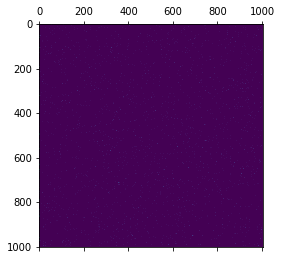

In [36]:
plt.matshow(np.sum(connection_result,axis=0))

In [36]:
# Value	Description
# 0	ROUTING_NOT_SOLVED: Problem not solved yet.
# 1	ROUTING_SUCCESS: Problem solved successfully.
# 2	ROUTING_FAIL: No solution found to the problem.
# 3	ROUTING_FAIL_TIMEOUT: Time limit reached before finding a solution.
# 4	ROUTING_INVALID: Model, model parameters, or flags are not valid.

In [13]:
i = 0
for vehicle_id in vehicle_route.keys():

    node_ls = vehicle_route[vehicle_id]['route']
    route_x = data['node_loc_ls'][0,node_ls]
    route_y = data['node_loc_ls'][1,node_ls]
    day_id = vehicle_route[vehicle_id]['day']
    plt.plot(route_x, route_y, c='C'+str(i))
    i += 1
# plt.legend()


plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=5)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=50,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len);
# plt.title('ordered customer')

KeyError: 'day'

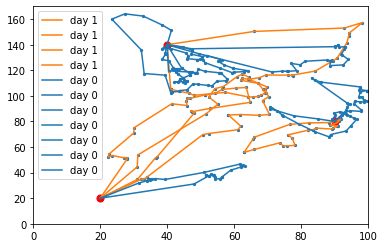

In [25]:
for vehicle_id in vehicle_route.keys():
    node_ls = vehicle_route[vehicle_id]['route']
    route_x = data['node_loc_ls'][0,node_ls]
    route_y = data['node_loc_ls'][1,node_ls]
    day_id = vehicle_route[vehicle_id]['day']
    plt.plot(route_x, route_y, c='C'+str(day_id),label='day '+str(day_id))
plt.legend()


plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=5)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=50,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len);
# plt.title('ordered customer')

# 方块划分

In [71]:
n_x_part = 4
n_y_part = 4

In [72]:
X_t = np.random.randint(2,size=(n_x_part*n_y_part))

In [73]:
which_part = np.zeros(N_order)
for i in range(n_x_part):
    x_part_min = i * x_len/n_x_part
    x_part_max = (i+1) * x_len/n_x_part
    for j in range(n_y_part):
        y_part_min = j * y_len/n_y_part
        y_part_max = (j+1) * y_len/n_y_part
        which_part[(order_loc_ls[0,:] >= x_part_min) & (order_loc_ls[0,:] <= x_part_max) &\
        (order_loc_ls[1,:] >= y_part_min) & (order_loc_ls[1,:] <= y_part_max)] = n_x_part*i+j
whether_served = [x in np.where(X_t)[0] for x in which_part]

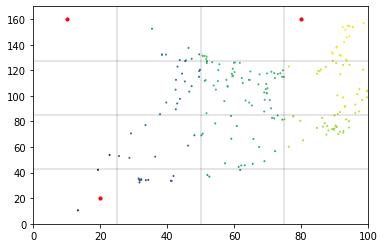

In [253]:
plt.scatter(order_loc_ls[0,:],order_loc_ls[1,:],s=1,c=which_part)
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len)
for j in range(n_y_part-1):
    plt.hlines((j+1)*y_len/n_y_part,xmin=0,xmax=x_len,lw=0.2)
for i in range(n_x_part-1):
    plt.vlines((i+1)*x_len/n_x_part,ymin=0,ymax=y_len,lw=0.2)

In [257]:
served_order_loc_ls = order_loc_ls[:,whether_served]
served_order_demands = order_demands[whether_served]
unserved_order_loc_ls = order_loc_ls[:,[not x for x in whether_served]]

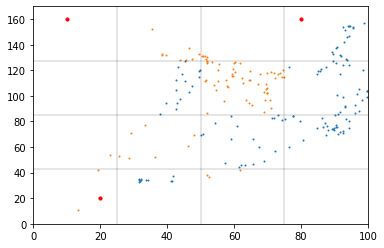

In [258]:
plt.scatter(served_order_loc_ls[0,:],served_order_loc_ls[1,:],s=1,c='C0')
plt.scatter(unserved_order_loc_ls[0,:],unserved_order_loc_ls[1,:],s=1,c='C1')
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len)
for j in range(n_y_part-1):
    plt.hlines((j+1)*y_len/n_y_part,xmin=0,xmax=x_len,lw=0.2)
for i in range(n_x_part-1):
    plt.vlines((i+1)*x_len/n_x_part,ymin=0,ymax=y_len,lw=0.2)

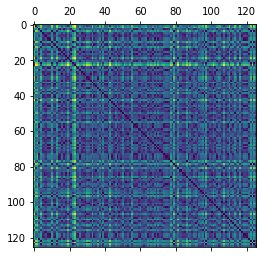

In [299]:
plt.matshow(create_data_model(served_order_loc_ls, depot_loc_ls, order_demands)['distance_matrix'])




In [300]:
"""Entry point of the program."""
time_start = time.time()
# Instantiate the data problem.
data = create_data_model(served_order_loc_ls, depot_loc_ls, order_demands)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['starts'],
                                       data['ends'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
# [START transit_callback]
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# [END transit_callback]

# Define cost of each arc.
# [START arc_cost]
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# [END arc_cost]

# Add Capacity constraint.
# [START capacity_constraint]
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# [END capacity_constraint]

# Setting first solution heuristic.
# [START parameters]
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.seconds = 10
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)


# search_parameters.local_search_metaheuristic = (
#     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
# search_parameters.log_search = True
# [END parameters]

# Solve the problem.
# [START solve]
solution = routing.SolveWithParameters(search_parameters)
# [END solve]

# Print solution on console.
# [START print_solution]
if solution:
    print_solution(data, manager, routing, solution)
# [END print_solution]

time_end = time.time()

print('time consumed: '+str(time_end - time_start))
print("Solver status: ", routing.status())

Route for vehicle 0:
 0 Load(0.0) ->  22 Load(9.0) ->  124 Load(17.0) ->  122 Load(23.0) ->  79 Load(30.0) ->  4 Load(37.0) ->  97 Load(44.0) ->  10 Load(50.0) ->  13 Load(56.0) ->  110 Load(62.0) ->  33 Load(70.0) ->  113 Load(78.0) ->  50 Load(83.0) ->  116 Load(92.0) ->  55 Load(101.0) ->  23 Load(107.0) ->  0 Load(107.0)
Distance of the route: 147m
Load of the route: 107.0

Route for vehicle 1:
 0 Load(0.0) ->  0 Load(0.0)
Distance of the route: 0m
Load of the route: 0.0

Route for vehicle 2:
 0 Load(0.0) ->  0 Load(0.0)
Distance of the route: 0m
Load of the route: 0.0

Route for vehicle 3:
 1 Load(0.0) ->  88 Load(7.0) ->  78 Load(14.0) ->  115 Load(21.0) ->  66 Load(27.0) ->  20 Load(33.0) ->  18 Load(41.0) ->  7 Load(47.0) ->  93 Load(53.0) ->  37 Load(62.0) ->  105 Load(67.0) ->  63 Load(76.0) ->  14 Load(84.0) ->  15 Load(91.0) ->  109 Load(99.0) ->  73 Load(106.0) ->  57 Load(112.0) ->  91 Load(119.0) ->  112 Load(128.0) ->  123 Load(137.0) ->  36 Load(144.0) ->  101 Load(151

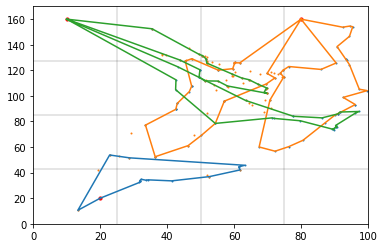

In [301]:
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    node_ls = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        node_ls.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
    node_ls.append(manager.IndexToNode(index))
    
    for i in range(N_depot):
        if i in node_ls:
            depot_used = i
    route_x = data['node_loc_ls'][0,node_ls]
    route_y = data['node_loc_ls'][1,node_ls]
    
    plt.plot(route_x, route_y, c='C'+str(depot_used))

# plt.scatter(served_order_loc_ls[0,:],served_order_loc_ls[1,:],s=1)
# plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=50,c=['C'+str(i) for i in range(N_depot)])
# plt.xlim(0,x_len)
# plt.ylim(0,y_len)


plt.scatter(served_order_loc_ls[0,:],served_order_loc_ls[1,:],s=1,c='C0')
plt.scatter(unserved_order_loc_ls[0,:],unserved_order_loc_ls[1,:],s=1,c='C1')
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len)


for j in range(n_y_part-1):
    plt.hlines((j+1)*y_len/n_y_part,xmin=0,xmax=x_len,lw=0.2)
for i in range(n_x_part-1):
    plt.vlines((i+1)*x_len/n_x_part,ymin=0,ymax=y_len,lw=0.2)

# Random Choice

In [297]:
whether_served = np.random.choice(N_order, 123)
# tmp = np.zeros(N_order)
# tmp[whether_served] = True
# whether_served = tmp

In [298]:
served_order_loc_ls = order_loc_ls[:,whether_served]
served_order_demands = order_demands[whether_served]
unserved_order_loc_ls = order_loc_ls[:,[not x for x in whether_served]]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 200 but corresponding boolean dimension is 123

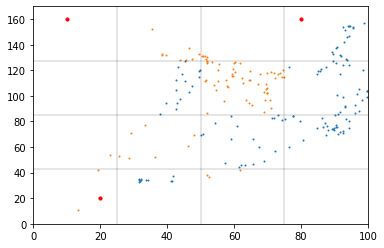

In [258]:
plt.scatter(served_order_loc_ls[0,:],served_order_loc_ls[1,:],s=1,c='C0')
plt.scatter(unserved_order_loc_ls[0,:],unserved_order_loc_ls[1,:],s=1,c='C1')
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len)
for j in range(n_y_part-1):
    plt.hlines((j+1)*y_len/n_y_part,xmin=0,xmax=x_len,lw=0.2)
for i in range(n_x_part-1):
    plt.vlines((i+1)*x_len/n_x_part,ymin=0,ymax=y_len,lw=0.2)

In [ ]:
plt.matshow(create_data_model(served_order_loc_ls, depot_loc_ls, order_demands)['distance_matrix'])




In [269]:
"""Entry point of the program."""
time_start = time.time()
# Instantiate the data problem.
data = create_data_model(served_order_loc_ls, depot_loc_ls, order_demands)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['starts'],
                                       data['ends'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
# [START transit_callback]
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# [END transit_callback]

# Define cost of each arc.
# [START arc_cost]
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# [END arc_cost]

# Add Capacity constraint.
# [START capacity_constraint]
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# [END capacity_constraint]

# Setting first solution heuristic.
# [START parameters]
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.seconds = 10
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)


# search_parameters.local_search_metaheuristic = (
#     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
# search_parameters.log_search = True
# [END parameters]

# Solve the problem.
# [START solve]
solution = routing.SolveWithParameters(search_parameters)
# [END solve]

# Print solution on console.
# [START print_solution]
if solution:
    print_solution(data, manager, routing, solution)
# [END print_solution]

time_end = time.time()

print('time consumed: '+str(time_end - time_start))
print("Solver status: ", routing.status())

Route for vehicle 0:
 0 Load(0.0) ->  60 Load(7.0) ->  36 Load(14.0) ->  62 Load(20.0) ->  4 Load(27.0) ->  48 Load(34.0) ->  73 Load(41.0) ->  0 Load(41.0)
Distance of the route: 36m
Load of the route: 41.0

Route for vehicle 1:
 0 Load(0.0) ->  5 Load(9.0) ->  72 Load(18.0) ->  88 Load(25.0) ->  86 Load(33.0) ->  118 Load(39.0) ->  90 Load(47.0) ->  38 Load(54.0) ->  6 Load(59.0) ->  35 Load(64.0) ->  15 Load(71.0) ->  56 Load(80.0) ->  76 Load(86.0) ->  31 Load(93.0) ->  17 Load(98.0) ->  16 Load(106.0) ->  42 Load(115.0) ->  41 Load(121.0) ->  20 Load(127.0) ->  87 Load(134.0) ->  8 Load(143.0) ->  117 Load(148.0) ->  92 Load(153.0) ->  82 Load(158.0) ->  100 Load(166.0) ->  40 Load(175.0) ->  65 Load(182.0) ->  111 Load(187.0) ->  101 Load(194.0) ->  0 Load(194.0)
Distance of the route: 238m
Load of the route: 194.0

Route for vehicle 2:
 0 Load(0.0) ->  0 Load(0.0)
Distance of the route: 0m
Load of the route: 0.0

Route for vehicle 3:
 1 Load(0.0) ->  74 Load(9.0) ->  84 Load(18.

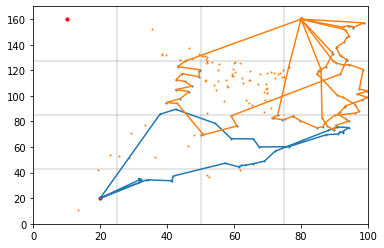

In [270]:
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    node_ls = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        node_ls.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
    node_ls.append(manager.IndexToNode(index))
    
    for i in range(N_depot):
        if i in node_ls:
            depot_used = i
    route_x = data['node_loc_ls'][0,node_ls]
    route_y = data['node_loc_ls'][1,node_ls]
    
    plt.plot(route_x, route_y, c='C'+str(depot_used))

# plt.scatter(served_order_loc_ls[0,:],served_order_loc_ls[1,:],s=1)
# plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=50,c=['C'+str(i) for i in range(N_depot)])
# plt.xlim(0,x_len)
# plt.ylim(0,y_len)


plt.scatter(served_order_loc_ls[0,:],served_order_loc_ls[1,:],s=1,c='C0')
plt.scatter(unserved_order_loc_ls[0,:],unserved_order_loc_ls[1,:],s=1,c='C1')
plt.scatter(depot_loc_ls[0,:],depot_loc_ls[1,:],s=10,c='r')
plt.xlim(0,x_len)
plt.ylim(0,y_len)


for j in range(n_y_part-1):
    plt.hlines((j+1)*y_len/n_y_part,xmin=0,xmax=x_len,lw=0.2)
for i in range(n_x_part-1):
    plt.vlines((i+1)*x_len/n_x_part,ymin=0,ymax=y_len,lw=0.2)